## 1 Import dependencies and load dataset

In [1]:
!pip install gensim underthesea
!pip install regex
!pip install pyvi
!pip install py_vncorenlp

In [2]:
!git clone https://github.com/NTT123/viwik18.git

fatal: destination path 'viwik18' already exists and is not an empty directory.


In [3]:
import re, unicodedata
import regex
from pyvi import ViTokenizer, ViPosTagger
import os
from tqdm import tqdm   
from underthesea import word_tokenize
from datetime import timedelta
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np
from numpy.linalg import norm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import logging
import time


In [4]:
folder = "viwik18/dataset"
output_file = "viwik18.txt"

with open(output_file, "w", encoding="utf-8") as out:
    for f_name in sorted(os.listdir(folder)):
        path = os.path.join(folder, f_name)
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            out.write(f.read())
            out.write("\n")
            
print(f"✅ Completed combining all files into {output_file}")

✅ Completed combining all files into viwik18.txt


## 2 Data Preprocecssing

Goal: convert raw text into a clean and consistent form, get ready for Word2Vec

**Main steps in the pipeline:**
1. Remove HTML tags: Strip `<script>`, `<style>`, and markup; keep only visible text.
2. Remove HTML entities: Remove `&amp`;, `&nbsp;`, `&#160;`
3. Convert encoding errors (Windows-1252 → UTF-8)  
4. Tokenization (Vietnamese word segmentation): Use a VN segmenter (e.g., `VnCoreNLP` / `underthesea` / `PyVi`) to split words.
5. Case normalization: Lowercase while preserving proper nouns and acronyms
6. Remove common tokens (emails, URLs, phones, dates, numbers, mentions): Regex out noise like `email@x`, `http(s)://…`, `@name`, phone/date patterns.
7. Remove emojis / emoticons: Drop Unicode emoji and ASCII emoticons (e.g., :), :D.  
8. Remove unwanted characters (non-Latin, _, extra spaces)
9. Normalize Vietnamese diacritics  
10. Strip whitespace  

In [5]:


# Regex patterns
RE_EMAIL = re.compile(r"([\w0-9_\.-]+)(@)([\d\w\.-]+)(\.)([\w\.]{2,6})")
RE_URL = re.compile(r"https?:\/\/(?!.*:\/\/)\S+")
RE_PHONE = re.compile(r"(09|01[2|6|8|9])+([0-9]{8})\b")
RE_MENTION = re.compile(r"@.+?:")
RE_NUMBER = re.compile(r"\d+\.?\d*")
RE_DATETIME = '\d{1,2}\s?[/-]\s?\d{1,2}\s?[/-]\s?\d{4}'
RE_HTML_TAG = re.compile(r'<[^>]+>')
RE_CLEAR_1 = regex.compile(r"[^_<>\s\p{Latin}]")  # requires 'regex' library
RE_CLEAR_2 = re.compile(r"__+")
RE_CLEAR_3 = re.compile(r"\s+")

KEEP_DIACRITICS = True # Keep Vietnamese diacritics when lower-casing

<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
C:\Users\PC\AppData\Local\Temp\ipykernel_34164\2296205555.py:7: SyntaxWarning: invalid escape sequence '\d'
  RE_DATETIME = '\d{1,2}\s?[/-]\s?\d{1,2}\s?[/-]\s?\d{4}'


In [6]:
def replace_common_token(txt):
  txt = re.sub(RE_EMAIL, ' ', txt)
  txt = re.sub(RE_URL, ' ', txt)
  txt = re.sub(RE_MENTION, ' ', txt)
  txt = re.sub(RE_DATETIME, ' ', txt)
  txt = re.sub(RE_NUMBER, ' ', txt)
  return txt

def remove_emoji(txt):
    txt = re.sub(r':v', '', txt)
    txt = re.sub(r':D', '', txt)
    txt = re.sub(r':3', '', txt)
    txt = re.sub(r':\(', '', txt)
    txt = re.sub(r':\)', '', txt)
    txt = re.sub(r'=\)*', '', txt)
    return txt

def remove_html_tag(txt):
    return re.sub(RE_HTML_TAG, ' ', txt)

def loaddicchar():
    dic = {}
    char1252 = (
        'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|'
        'è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|'
        'ì|í|ỉ|ĩ|ị|'
        'ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|'
        'ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|'
        'ỳ|ý|ỷ|ỹ|ỵ|'
        'À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|'
        'È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|'
        'Ì|Í|Ỉ|Ĩ|Ị|'
        'Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|'
        'Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|'
        'Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    ).split('|')

    charutf8 = (
        'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|'
        'è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|'
        'ì|í|ỉ|ĩ|ị|'
        'ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|'
        'ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|'
        'ỳ|ý|ỷ|ỹ|ỵ|'
        'À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|'
        'È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|'
        'Ì|Í|Ỉ|Ĩ|Ị|'
        'Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|'
        'Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|'
        'Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    ).split('|')

    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

dicchar = loaddicchar()

def convertwindown1525toutf8(txt):
    """
    Convert Vietnamese text from Windows-1252/VNI encoding errors
    to proper UTF-8 Unicode.
    """
    return re.sub(
        '|'.join(dicchar.keys()),  # regex khớp toàn bộ các ký tự lỗi
        lambda x: dicchar[x.group()],
        txt
    )

In [7]:
bang_nguyen_am = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]
bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']

nguyen_am_to_ids = {}

for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)

In [8]:
def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x != -1:
            if nguyen_am_index == -1:
                nguyen_am_index = index
            else:
                if index - nguyen_am_index != 1:
                    return False
                nguyen_am_index = index
    return True

In [9]:
def chuan_hoa_dau_tu_tieng_viet(word):
    """
    Normalize tone marks in a single Vietnamese word.
    Ensures tone marks are placed on the correct vowel
    according to Vietnamese orthography.
    Example: 'hoà' -> 'hoà', 'thỏai' -> 'thoải', 'úy' -> 'úy'
    """
    if not is_valid_vietnam_word(word):
        return word

    chars = list(word)
    dau_cau = 0              # tone mark type (sắc, huyền, hỏi, ngã, nặng)
    nguyen_am_index = []     # indexes of vowels in the word
    qu_or_gi = False         # special case flag for "qu" and "gi"

    # Scan each character
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            continue

        # Special case "qu": treat 'u' after 'q' as a consonant
        if x == 9 and index > 0 and chars[index - 1] == 'q':
            chars[index] = 'u'
            qu_or_gi = True

        # Special case "gi": treat 'i' after 'g' as a consonant
        elif x == 5 and index > 0 and chars[index - 1] == 'g':
            chars[index] = 'i'
            qu_or_gi = True

        # If this vowel has a tone mark → record it
        if y != 0:
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0]  # reset to base vowel

        # Record vowel index unless it's part of "qu"/"gi"
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)

    # Case: no valid vowels
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                # "gi", "qu" cases with 2 letters
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                # longer word with "gi"/"qu"
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    # fallback: put tone on i or u
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word

    # Case: if the word contains ê or ơ → always put the tone there
    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            return ''.join(chars)

    # Case: word has 2 vowels
    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            # If last vowel is at the end → tone goes to the first vowel
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
        else:
            # Otherwise → tone goes to the second vowel
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]

    # Case: word has 3 vowels (e.g., "khuyên")
    else:
        # Place tone on the middle vowel
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]

    return ''.join(chars)

In [10]:
def chuan_hoa_dau_cau_tieng_viet(sentence):
    """
        Chuyển câu tiếng việt về chuẩn gõ dấu kiểu cũ.
        :param sentence:
        :return:
        """
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        words[index] = chuan_hoa_dau_tu_tieng_viet(word)
    return ' '.join(words)

In [12]:
def preprocess(txt):
    # 1. Remove HTML tags
    txt = remove_html_tag(txt)

    # 2. Remove HTML entities like &nbsp; &amp; ...
    txt = re.sub('&.{3,4};', ' ', txt)

    # 3. Convert Windows-1252/VNI encoding errors to UTF-8
    txt = convertwindown1525toutf8(txt)
    
    # 4. Tokenize Vietnamese text
    txt = ViTokenizer.tokenize(txt)

    # 5. Smart lowercase (POS tagging)
    txt = txt.lower() 
    
    # 6. Remove common tokens (emails, URLs, mentions, dates, numbers, phones)
    txt = replace_common_token(txt)

    # 7. Remove emojis and emoticons
    txt = remove_emoji(txt)

    # 8. Remove unwanted characters
    txt = RE_CLEAR_1.sub(" ", txt)  # non-Latin chars
    txt = RE_CLEAR_2.sub(" ", txt)  # collapse multiple underscores
    txt = RE_CLEAR_3.sub(" ", txt)  # collapse multiple spaces

    # 9. Normalize Vietnamese diacritics
    txt = chuan_hoa_dau_tu_tieng_viet(txt)
    
    # 10. Strip leading/trailing whitespace
    return txt.strip()

In [13]:
IN_DIR = "viwik18/dataset"  # Original file (one very long line)
OUT_DIR = "dataset_split"   # Output file (split into shorter lines)
WORDS_PER_LINE = 500        # Around 500 words per line (suitable for Word2Vec)

os.makedirs(OUT_DIR, exist_ok=True)

print(f"\n{'='*70}")
print(f"✂️  SPLITTING LONG LINES INTO SHORTER ONES")
print(f"📁 Input:  {IN_DIR}")
print(f"📁 Output: {OUT_DIR}")
print(f"📏 Words per line: ~{WORDS_PER_LINE}")
print(f"{'='*70}\n")


✂️  SPLITTING LONG LINES INTO SHORTER ONES
📁 Input:  viwik18/dataset
📁 Output: dataset_split
📏 Words per line: ~500



In [14]:
def split_into_chunks(text, chunk_size=WORDS_PER_LINE):
    """
    Chia text thành các chunk nhỏ.
    Mỗi chunk ~chunk_size từ.
    """
    words = text.split()
    chunks = []
    
    for i in range(0, len(words), chunk_size):
        chunk = " ".join(words[i:i+chunk_size])
        if len(chunk.strip()) > 10:  # Bỏ chunk quá ngắn
            chunks.append(chunk)
    
    return chunks

def process_file(src, dst):
    """Xử lý 1 file: chia dòng dài thành nhiều dòng ngắn."""
    
    file_size = os.path.getsize(src)
    file_size_mb = file_size / (1024**2)
    
    print(f"  📖 Đọc file ({file_size_mb:.1f}MB)...")
    
    # Đọc TOÀN BỘ file (vì chỉ có 1 dòng dài)
    # Dùng read() thay vì readline()
    with open(src, 'r', encoding='utf-8', errors='ignore') as f:
        # Đọc từng chunk để tránh OOM với file cực lớn
        CHUNK_SIZE = 10 * 1024 * 1024  # 10MB mỗi lần đọc
        
        all_text = ""
        print(f"  📊 Đọc từng chunk 10MB...")
        
        while True:
            chunk = f.read(CHUNK_SIZE)
            if not chunk:
                break
            all_text += chunk
    
    print(f"  ✂️  Chia thành các dòng ngắn...")
    
    # Chia thành các dòng ngắn
    lines = split_into_chunks(all_text, WORDS_PER_LINE)
    
    print(f"  💾 Ghi {len(lines):,} dòng...")
    
    # Ghi file với buffer lớn
    with open(dst, 'w', encoding='utf-8', buffering=4<<20) as f:
        for line in lines:
            f.write(line + '\n')
    
    return len(lines)

In [15]:
files = sorted([f for f in os.listdir(IN_DIR)
                if os.path.isfile(os.path.join(IN_DIR, f))
                and not f.startswith('.')])

if not files:
    print("❌ No .txt files found in", IN_DIR)
    exit(1)

print(f"🎯 Found {len(files)} files\n")

import time
start_time = time.time()
total_lines = 0

for idx, fname in enumerate(files, 1):
    src = os.path.join(IN_DIR, fname)
    dst = os.path.join(OUT_DIR, fname)

    file_size_mb = os.path.getsize(src) / (1024**2)

    print(f"[{idx}/{len(files)}] {fname} ({file_size_mb:.1f}MB)")

    file_start = time.time()

    lines = process_file(src, dst)

    file_time = time.time() - file_start
    total_lines += lines

    print(f"  ✅ {lines:,} lines processed in {file_time:.1f}s\n")

total_time = time.time() - start_time

print(f"{'='*70}")
print(f"✅ COMPLETED!")
print(f"⏱️  Total time: {total_time:.1f}s")
print(f"📝 Total lines: {total_lines:,}")
print(f"📁 Output folder: {OUT_DIR}")
print(f"{'='*70}\n")

🎯 Found 10 files

[1/10] viwik18_aa (90.0MB)
  📖 Đọc file (90.0MB)...
  📊 Đọc từng chunk 10MB...
  ✂️  Chia thành các dòng ngắn...
  💾 Ghi 31,665 dòng...
  ✅ 31,665 lines processed in 3.7s

[2/10] viwik18_ab (90.0MB)
  📖 Đọc file (90.0MB)...
  📊 Đọc từng chunk 10MB...
  ✂️  Chia thành các dòng ngắn...
  💾 Ghi 31,667 dòng...
  ✅ 31,667 lines processed in 3.9s

[3/10] viwik18_ac (90.0MB)
  📖 Đọc file (90.0MB)...
  📊 Đọc từng chunk 10MB...
  ✂️  Chia thành các dòng ngắn...
  💾 Ghi 31,545 dòng...
  ✅ 31,545 lines processed in 3.3s

[4/10] viwik18_ad (90.0MB)
  📖 Đọc file (90.0MB)...
  📊 Đọc từng chunk 10MB...
  ✂️  Chia thành các dòng ngắn...
  💾 Ghi 31,449 dòng...
  ✅ 31,449 lines processed in 2.4s

[5/10] viwik18_ae (90.0MB)
  📖 Đọc file (90.0MB)...
  📊 Đọc từng chunk 10MB...
  ✂️  Chia thành các dòng ngắn...
  💾 Ghi 30,039 dòng...
  ✅ 30,039 lines processed in 2.2s

[6/10] viwik18_af (90.0MB)
  📖 Đọc file (90.0MB)...
  📊 Đọc từng chunk 10MB...
  ✂️  Chia thành các dòng ngắn...
  💾 Ghi 3

In [16]:
def process_file(src, dst):
    """Process file sequentially (no multiprocessing)."""
    print(f"  📖 Reading file...")
    
    # Read file
    with open(src, 'r', encoding='utf-8', errors='ignore') as f:
        all_lines = [line for line in f]
    
    total_lines = len(all_lines)
    print(f"  📊 {total_lines:,} lines")
    
    print(f"  🔄 Processing (sequential)...")
    
    # Process with progress bar
    results = []
    
    with tqdm(total=total_lines, desc="  Progress", unit="line") as pbar:
        for line in all_lines:
            result = preprocess(line)
            if result:
                results.append(result)
            
            # Update every 100 lines to reduce overhead
            if len(results) % 100 == 0:
                pbar.update(100)
                pbar.set_postfix({'lines/s': f'{len(results)/pbar.format_dict["elapsed"]:.0f}'})
        
        # Update remaining
        pbar.update(total_lines - pbar.n)
    
    # Write output
    print(f"  💾 Writing file...")
    with open(dst, 'w', encoding='utf-8', buffering=4<<20) as f:
        for line in results:
            f.write(line + '\n')
    
    return len(results)

In [17]:

IN_DIR = "dataset_split"        # Input directory with split files
OUT_DIR = "dataset_preprocessed"   # Output directory for tokenized files

# Create output directory if it doesn't exist
os.makedirs(OUT_DIR, exist_ok=True)

files = sorted([f for f in os.listdir(IN_DIR) 
                if os.path.isfile(os.path.join(IN_DIR, f)) 
                and not f.startswith('.')])

print(f"\n{'='*70}")
print(f"🐌 SEQUENTIAL TOKENIZATION (No Multiprocessing)")
print(f"📁 {IN_DIR} → {OUT_DIR}")
print(f"⚠️  Slower but more reliable")
print(f"⏱️  Expected: 30-100 lines/s")
print(f"{'='*70}\n")

if not files:
    print(f"❌ No files found in {IN_DIR}")
    exit(1)

start = time.time()
total = 0

for idx, fname in enumerate(files, 1):
    src = os.path.join(IN_DIR, fname)
    dst = os.path.join(OUT_DIR, fname)
    
    print(f"[{idx}/{len(files)}] {fname} ({os.path.getsize(src)/1024**2:.1f}MB)")
    
    t = time.time()
    lines = process_file(src, dst)
    elapsed = time.time() - t
    
    total += lines
    print(f"  ✅ {lines:,} lines | {elapsed:.1f}s | {lines/elapsed:.0f} lines/s\n")

print(f"{'='*70}")
print(f"✅ DONE! {total:,} lines | {str(timedelta(seconds=int(time.time()-start)))}")
print(f"📁 {OUT_DIR}")
print(f"{'='*70}\n")


🐌 SEQUENTIAL TOKENIZATION (No Multiprocessing)
📁 dataset_split → dataset_preprocessed
⚠️  Slower but more reliable
⏱️  Expected: 30-100 lines/s

[1/10] viwik18_aa (89.4MB)
  📖 Reading file...
  📊 31,665 lines
  🔄 Processing (sequential)...


  Progress: 100%|██████████| 31665/31665 [03:06<00:00, 169.37line/s, lines/s=169]


  💾 Writing file...
  ✅ 31,665 lines | 188.0s | 168 lines/s

[2/10] viwik18_ab (89.3MB)
  📖 Reading file...
  📊 31,667 lines
  🔄 Processing (sequential)...


  Progress: 100%|██████████| 31667/31667 [02:40<00:00, 197.48line/s, lines/s=197]


  💾 Writing file...
  ✅ 31,667 lines | 161.1s | 197 lines/s

[3/10] viwik18_ac (89.0MB)
  📖 Reading file...
  📊 31,545 lines
  🔄 Processing (sequential)...


  Progress: 100%|██████████| 31545/31545 [02:37<00:00, 200.04line/s, lines/s=200]


  💾 Writing file...
  ✅ 31,545 lines | 158.5s | 199 lines/s

[4/10] viwik18_ad (89.1MB)
  📖 Reading file...
  📊 31,449 lines
  🔄 Processing (sequential)...


  Progress: 100%|██████████| 31449/31449 [02:36<00:00, 200.57line/s, lines/s=201]


  💾 Writing file...
  ✅ 31,449 lines | 157.6s | 200 lines/s

[5/10] viwik18_ae (88.6MB)
  📖 Reading file...
  📊 30,039 lines
  🔄 Processing (sequential)...


  Progress: 100%|██████████| 30039/30039 [02:30<00:00, 199.08line/s, lines/s=199]


  💾 Writing file...
  ✅ 30,039 lines | 151.6s | 198 lines/s

[6/10] viwik18_af (88.6MB)
  📖 Reading file...
  📊 30,141 lines
  🔄 Processing (sequential)...


  Progress: 100%|██████████| 30141/30141 [02:29<00:00, 201.00line/s, lines/s=201]


  💾 Writing file...
  ✅ 30,141 lines | 150.6s | 200 lines/s

[7/10] viwik18_ag (88.7MB)
  📖 Reading file...
  📊 30,268 lines
  🔄 Processing (sequential)...


  Progress: 100%|██████████| 30268/30268 [02:30<00:00, 200.58line/s, lines/s=201]


  💾 Writing file...
  ✅ 30,268 lines | 151.6s | 200 lines/s

[8/10] viwik18_ah (88.6MB)
  📖 Reading file...
  📊 29,716 lines
  🔄 Processing (sequential)...


  Progress: 100%|██████████| 29716/29716 [02:29<00:00, 199.14line/s, lines/s=199]


  💾 Writing file...
  ✅ 29,716 lines | 149.9s | 198 lines/s

[9/10] viwik18_ai (89.2MB)
  📖 Reading file...
  📊 31,548 lines
  🔄 Processing (sequential)...


  Progress: 100%|██████████| 31548/31548 [02:36<00:00, 201.51line/s, lines/s=202]


  💾 Writing file...
  ✅ 31,548 lines | 157.3s | 200 lines/s

[10/10] viwik18_aj (63.8MB)
  📖 Reading file...
  📊 22,569 lines
  🔄 Processing (sequential)...


  Progress: 100%|██████████| 22569/22569 [01:51<00:00, 202.20line/s, lines/s=202]


  💾 Writing file...
  ✅ 22,569 lines | 112.2s | 201 lines/s

✅ DONE! 300,607 lines | 0:25:38
📁 dataset_preprocessed



## 3 Training Word2Vec Representation

**Goal:**  
Train a Vietnamese Word2Vec model to learn meaningful word embeddings from the cleaned corpus.

### 🔹 Steps in the pipeline
1. **Set hyperparameters:**  
   Define vector size (300), window (5), min count (3), epochs (10), algorithm (Skip-gram).

2. **Load data:**  
   Use a `SentenceIterator` to stream preprocessed sentences efficiently from all files.

3. **Train model:**  
   Use `gensim.Word2Vec` with logging to track progress and loss over 10 epochs.

4. **Save outputs:**  
   - `word2vec.model` → full model  
   - `word2vec.wordvectors` → embeddings only  
   - `word2vec.txt` → readable text format

### 3.1 Set hyperparameters

In [18]:
DATA_DIR = "dataset_preprocessed"    
MODEL_DIR = "word2vec_model" 

VECTOR_SIZE = 100    # Dimension of word vectors (100-300 typical)
WINDOW = 5           # How many words to look at on each side
MIN_COUNT = 5        # Removes rare words to save memory
EPOCHS = 10          # More epochs = better quality but slower
SG = 1               # Skip-gram (1) or CBOW (0)

print(f"\n{'='*70}")
print(f"🤖 TRAINING WORD2VEC")
print(f"{'='*70}")
print(f"📁 Data directory: {DATA_DIR}")
print(f"💾 Model directory: {MODEL_DIR}")
print(f"\n⚙️  HYPERPARAMETERS:")
print(f"   • Vector size: {VECTOR_SIZE}")
print(f"   • Window: {WINDOW}")
print(f"   • Min count: {MIN_COUNT}")
print(f"   • Epochs: {EPOCHS}")
print(f"   • Algorithm: {'Skip-gram' if SG else 'CBOW'}")
print(f"{'='*70}\n")


🤖 TRAINING WORD2VEC
📁 Data directory: dataset_preprocessed
💾 Model directory: word2vec_model

⚙️  HYPERPARAMETERS:
   • Vector size: 100
   • Window: 5
   • Min count: 5
   • Epochs: 10
   • Algorithm: Skip-gram



### 3.2 Load Data

In [19]:
class SentenceIterator:
    def __init__(self, dirname):
        self.dirname = dirname
        # Get all files in directory
        self.files = sorted(f for f in os.listdir(dirname))
        
    def __iter__(self):
        """Iterate through all sentences in all files"""
        for fname in self.files:
            file_path = os.path.join(self.dirname, fname)
            
            with open(file_path, "r", encoding='utf-8') as f:
                for line in f:
                    line = line.strip()
                    
                    if not line:
                        continue
                    
                    # Split line into words
                    words = line.split()
                    
                    if len(words) >= 2:
                        yield words
                        
print("📖 Loading sentences...")
sentences = SentenceIterator(DATA_DIR)

print("📊 Counting sentences (this may take a moment)...")
total_sentences = sum(1 for _ in SentenceIterator(DATA_DIR))
print(f"   Total: {total_sentences:,} sentences\n")

print("🏋️  Training Word2Vec model...")
print("   (This will take 30-60 minutes depending on data size)\n")

📖 Loading sentences...
📊 Counting sentences (this may take a moment)...
   Total: 300,607 sentences

🏋️  Training Word2Vec model...
   (This will take 30-60 minutes depending on data size)



### 3.3 Train Model

In [20]:
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s',
    level=logging.INFO
)

start_time = time.time()

model = Word2Vec(
    sentences=sentences,
    vector_size=300,
    window=5,
    min_count=3,
    epochs=10,
    sg=1,
    compute_loss=True
)

train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")


2025-10-09 06:43:24,963 : INFO : collecting all words and their counts
2025-10-09 06:43:24,964 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-10-09 06:43:25,826 : INFO : PROGRESS: at sentence #10000, processed 3988689 words, keeping 78532 word types
2025-10-09 06:43:26,747 : INFO : PROGRESS: at sentence #20000, processed 8012497 words, keeping 132851 word types
2025-10-09 06:43:27,693 : INFO : PROGRESS: at sentence #30000, processed 12052311 words, keeping 176924 word types
2025-10-09 06:43:28,634 : INFO : PROGRESS: at sentence #40000, processed 16111530 words, keeping 218008 word types
2025-10-09 06:43:29,587 : INFO : PROGRESS: at sentence #50000, processed 20172447 words, keeping 254359 word types
2025-10-09 06:43:30,554 : INFO : PROGRESS: at sentence #60000, processed 24279837 words, keeping 290954 word types
2025-10-09 06:43:31,513 : INFO : PROGRESS: at sentence #70000, processed 28390596 words, keeping 324559 word types
2025-10-09 06:43:32,483 : IN

Training completed in 5750.94 seconds


### 3.4 Save Model

In [21]:
print("\n💾 Saving model...")

# Save full model (can continue training)
os.makedirs(MODEL_DIR, exist_ok=True)
model_path = os.path.join(MODEL_DIR, "word2vec.model")
model.save(model_path)

# Save word vectors only (faster to load, smaller file)
wv_path = os.path.join(MODEL_DIR, "word2vec.wordvectors")
model.wv.save(wv_path)

# Save in text format (human-readable, compatible with other tools)
txt_path = os.path.join(MODEL_DIR, "word2vec.txt")
model.wv.save_word2vec_format(txt_path, binary=False)

2025-10-09 08:19:15,923 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'word2vec_model\\word2vec.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-10-09T08:19:15.923054', 'gensim': '4.3.3', 'python': '3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'saving'}
2025-10-09 08:19:15,929 : INFO : storing np array 'vectors' to word2vec_model\word2vec.model.wv.vectors.npy



💾 Saving model...


2025-10-09 08:19:16,689 : INFO : storing np array 'syn1neg' to word2vec_model\word2vec.model.syn1neg.npy
2025-10-09 08:19:17,390 : INFO : not storing attribute cum_table
2025-10-09 08:19:17,699 : INFO : saved word2vec_model\word2vec.model
2025-10-09 08:19:17,702 : INFO : KeyedVectors lifecycle event {'fname_or_handle': 'word2vec_model\\word2vec.wordvectors', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-10-09T08:19:17.702314', 'gensim': '4.3.3', 'python': '3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'saving'}
2025-10-09 08:19:17,702 : INFO : storing np array 'vectors' to word2vec_model\word2vec.wordvectors.vectors.npy
2025-10-09 08:19:18,620 : INFO : saved word2vec_model\word2vec.wordvectors
2025-10-09 08:19:19,023 : INFO : storing 500577x300 projection weights into word2vec_model\word2vec.txt


In [22]:
print(f"\n{'='*70}")
print(f"✅ TRAINING COMPLETED!")
print(f"{'='*70}")
print(f"⏱️  Training time: {str(timedelta(seconds=int(train_time)))}")
print(f"📚 Vocabulary size: {len(model.wv):,} words")
print(f"💾 Model saved to:")
print(f"   • Full model: {model_path}")
print(f"   • Word vectors: {wv_path}")
print(f"   • Text format: {txt_path}")
print(f"{'='*70}\n")


✅ TRAINING COMPLETED!
⏱️  Training time: 1:35:50
📚 Vocabulary size: 500,577 words
💾 Model saved to:
   • Full model: word2vec_model\word2vec.model
   • Word vectors: word2vec_model\word2vec.wordvectors
   • Text format: word2vec_model\word2vec.txt



# 4 Testing Word2Vec and Visualizing

**Goal:**  
Evaluate and visualize the trained Vietnamese Word2Vec model to ensure that it captures semantic and syntactic relationships between words.

In [23]:
# Load model
model = Word2Vec.load('word2vec_model/word2vec.model')

# Load only word vectors (faster and smaller)
w2v = KeyedVectors.load('word2vec_model/word2vec.wordvectors')

2025-10-09 08:20:45,406 : INFO : loading Word2Vec object from word2vec_model/word2vec.model
2025-10-09 08:20:45,677 : INFO : loading wv recursively from word2vec_model/word2vec.model.wv.* with mmap=None
2025-10-09 08:20:45,677 : INFO : loading vectors from word2vec_model/word2vec.model.wv.vectors.npy with mmap=None
2025-10-09 08:20:45,916 : INFO : loading syn1neg from word2vec_model/word2vec.model.syn1neg.npy with mmap=None
2025-10-09 08:20:46,145 : INFO : setting ignored attribute cum_table to None
2025-10-09 08:20:52,363 : INFO : Word2Vec lifecycle event {'fname': 'word2vec_model/word2vec.model', 'datetime': '2025-10-09T08:20:52.363096', 'gensim': '4.3.3', 'python': '3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'loaded'}
2025-10-09 08:20:52,496 : INFO : loading KeyedVectors object from word2vec_model/word2vec.wordvectors
2025-10-09 08:20:52,734 : INFO : loading vectors from word2vec

### 4.1 Testing Model

In [24]:
# Get the word 
vector = model.wv['học_sinh']
print(vector.shape)

(300,)


In [25]:
# ===== SIMILARITY TESTS =====
print(f"{'='*70}")
print(f"🧪 TESTING MODEL")
print(f"{'='*70}\n")

test_words = [
    "việt_nam",
    "học_sinh", 
    "sinh_viên",
    "giáo_dục",
    "công_nghệ",
    "kinh_tế"
]

print("Testing word similarity...\n")

for word in test_words:
    if word in model.wv:
        print(f"✅ '{word}' - Found in vocabulary")
        
        try:
            # Find most similar words
            similar = model.wv.most_similar(word, topn=5)
            print(f"   Similar words:")
            for similar_word, score in similar:
                print(f"      {similar_word}: {score:.3f}")
        except:
            print(f"   (Could not compute similarities)")
    else:
        print(f"❌ '{word}' - Not in vocabulary")
        print(f"   (Word appears less than {MIN_COUNT} times in corpus)")
    
    print()

🧪 TESTING MODEL

Testing word similarity...

✅ 'việt_nam' - Found in vocabulary
   Similar words:
      việt: 0.725
      trung_quốc: 0.656
      vietbook: 0.589
      nam_liên: 0.585
      nam_trung_ương: 0.572

✅ 'học_sinh' - Found in vocabulary
   Similar words:
      sinh_viên: 0.805
      giáo_viên: 0.712
      năm_học: 0.698
      năm_học_sinh: 0.692
      trung_học: 0.683

✅ 'sinh_viên' - Found in vocabulary
   Similar words:
      học_sinh: 0.805
      giảng_viên: 0.658
      xã_hội_giảng_viên: 0.656
      giáo_viên: 0.650
      đại_học_sinh_viên: 0.647

✅ 'giáo_dục' - Found in vocabulary
   Similar words:
      công_nghệ_sở: 0.700
      đào_tạo: 0.674
      y_tế: 0.672
      xã_hội_trường: 0.667
      sức_khỏe_khoa: 0.660

✅ 'công_nghệ' - Found in vocabulary
   Similar words:
      kỹ_thuật: 0.753
      công_nghệ_vật_liệu: 0.700
      công_nghệ_cơ_khí: 0.685
      công_nghệ_nhiệt: 0.672
      hóa_khoa: 0.669

✅ 'kinh_tế' - Found in vocabulary
   Similar words:
      tài_chính:

In [26]:
# ===== WORD SIMILARITY =====

# Compute similarity between two words
score = model.wv.similarity('học_sinh', 'sinh_viên')
print(f"Similarity: {score:.3f}")

# ===== WORD ANALOGY =====

# Vector arithmetic: king - man + women = queen
# Example: việt_nam - hà_nội + ??? = ???
result = model.wv.most_similar(
    positive=['anh', 'nam'],
    negative=['nữ'],
    topn=5
)

print(result)

Similarity: 0.805
[('bắc', 0.4785350263118744), ('hurlford', 0.4338875412940979), ('southsea', 0.432694673538208), ('bắc_ireland', 0.43090859055519104), ('ông', 0.4300602674484253)]


In [27]:
# ===== CONVERT SENTENCE TO VECTOR =====
def sentence_to_vector(sentence, model):
    '''
    Convert a sentence to vector by averaging word vectors.
    Args:
        sentence: Tokenized sentence (e.g., "học_sinh giỏi")
        model: Trained Word2Vec model
    
    Returns:
        numpy array of shape (300,) or None if no words in vocab
    '''
    words = sentence.split()
    
    # Get vectors for all words that exist in vocabulary
    vectors = []
    for word in words:
        if word in model.wv:
            vectors.append(model.wv[word])
            
    if not  vectors:
        return None
    
    return np.mean(vectors, axis=0)

# Example
sentence = "học sinh giỏi của trường"
sentence = preprocess(sentence)
vec = sentence_to_vector(sentence, model)
print(vec.shape)

(300,)


In [28]:
# ===== COMPUTE SENTENCE SIMILARITY =====
def sentence_similarity(sent1, sent2, model):
    '''Compute cosine similarity between two sentences.'''
    vec1 = sentence_to_vector(sent1, model)
    vec2 = sentence_to_vector(sent2, model)
    
    # Compute cosine similarity
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

sent1 = "học sinh giỏi"
sent2 = "sinh viên xuất sắc"
sent1 = preprocess(sent1)
sent2 = preprocess(sent2)

sim = sentence_similarity(sent1, sent2, model)
print(f"Similarity: {sim:.3f}")

Similarity: 0.666


In [29]:
# ===== FIND OUTLIER =====
# Find word that doesn't match others
outlier = model.wv.doesnt_match(['học_sinh', 'sinh_viên', 'giáo_viên', 'tủ'])

print(f"Outlier: {outlier}")

Outlier: tủ


### 4.2 Visualzing Word2Vec using PCA

✅ Visualizing 100 words
✅ Visualizing 100 words
🔄 Applying PCA...


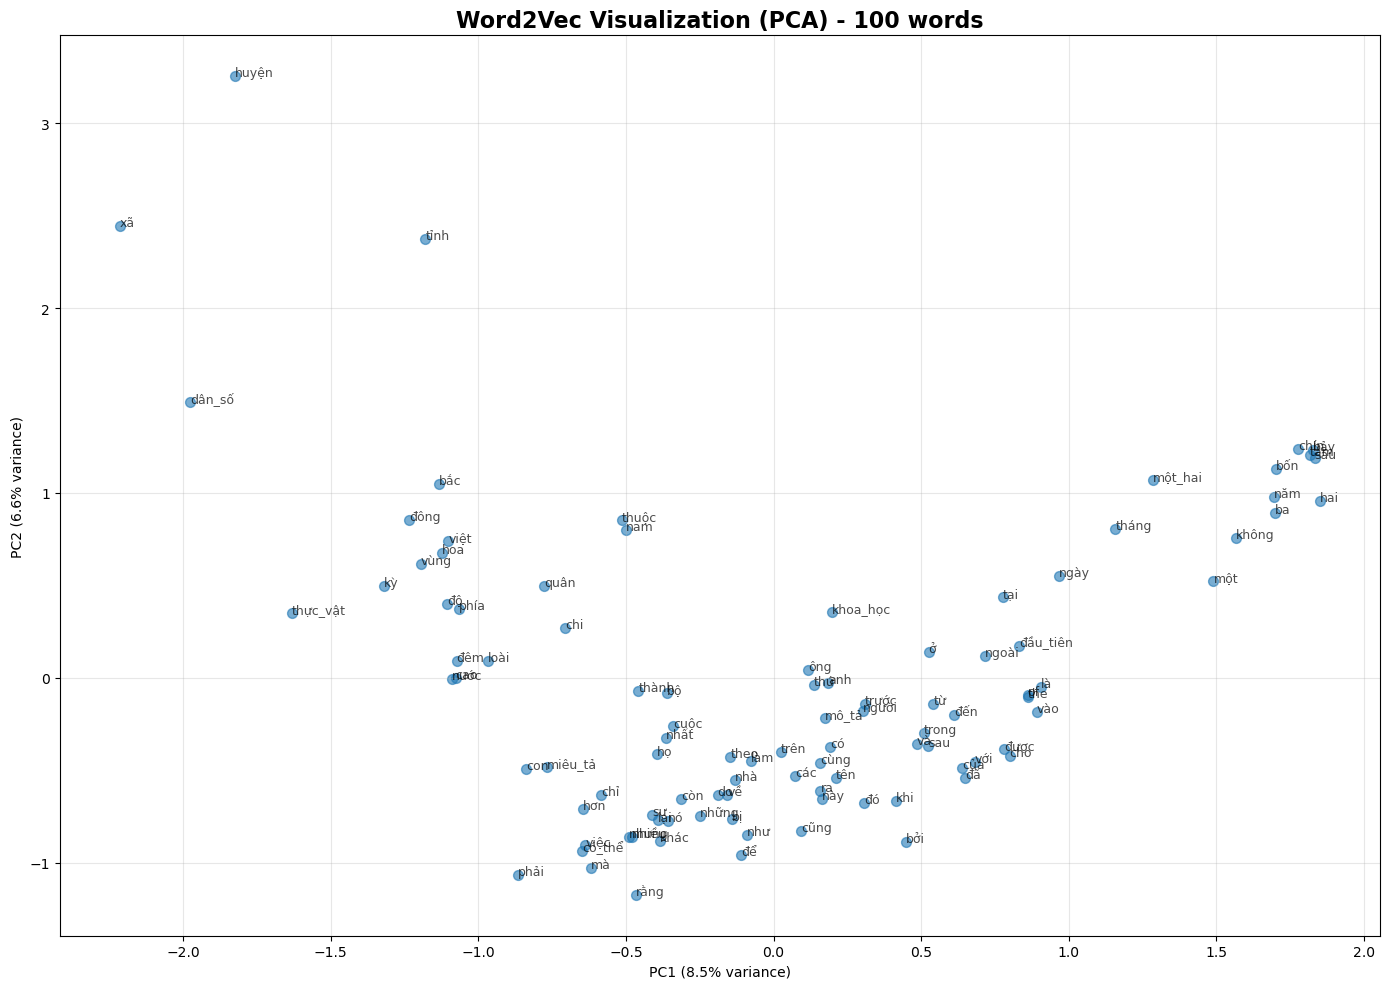

In [30]:
# ===== SIMPLE PCA VISUALIZATION FOR WORD2VEC =====


N_WORDS = 100  # Number of words to visualize

# Get top N most frequent words
words = list(model.wv.index_to_key[:N_WORDS])
print(f"✅ Visualizing {len(words)} words")

# Get top N most frequent words
words = list(model.wv.index_to_key[:N_WORDS])
print(f"✅ Visualizing {len(words)} words")

# Get word vectors (100D)
vectors = np.array([model.wv[word] for word in words])

# Apply PCA to reduce 100D → 2D
print("🔄 Applying PCA...")
pca = PCA(n_components=2, random_state=42)
vectors_2d = pca.fit_transform(vectors)

# Create plot
plt.figure(figsize=(14, 10))

# Scatter plot
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.6, s=50)

# Add word labels
for i, word in enumerate(words):
    plt.text(
        vectors_2d[i, 0], 
        vectors_2d[i, 1], 
        word, 
        fontsize=9,
        alpha=0.7
    )

# Plot settings
explained_var = pca.explained_variance_ratio_
plt.title(f'Word2Vec Visualization (PCA) - {len(words)} words', 
          fontsize=16, fontweight='bold')
plt.xlabel(f'PC1 ({explained_var[0]:.1%} variance)')
plt.ylabel(f'PC2 ({explained_var[1]:.1%} variance)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
